# Image classification

## Import packages

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, GlobalAveragePooling2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorboard.plugins.hparams import api as hp
# from tensorflow.keras import optimizers

import os
import numpy as np
import matplotlib.pyplot as plt
#import datetime
from pathlib import Path, PureWindowsPath

from datetime import datetime    # per calcolare tempi di esecuzione

## Load data

In [2]:
start_time = datetime.now()

# SET DIR DATASET AND IMAGE TRAIN DIR# SET DIR DATASET AND IMAGE TRAIN DIR
import sys

if sys.platform.startswith('darwin'):
    DataSet = '/Volumes/Dati/DL_Dataset/'     
    PathImg = 'VOCdevkit/VOC2012/ImgForClass_Reduce/'   
    # 'Intel_Image-Classification/seg_train/' ; 'coco-animals/' ; 'VOCdevkit/VOC2012/ImgForClass_Reduce/'
    
elif sys.platform.startswith('linux'):
    DataSet = '/content/drive/My Drive/DataSets/'     
    PathImg = 'VOCdevkit/VOC2012/ImgForClass_Reduce/'
    
elif sys.platform.startswith('win'):
    DataSet = 'E:'     
    PathImg = os.path.join('PROVA_COCO', 'ImgForClass')
    # 'Intel_Image-Classification\\seg_train\\' ; 'PROVA_COCO\\ImgForClass\\' ; 'VOCdevkit\\VOC2012\\ImgForClass_Reduce\\'
    
else:
    print('altro')
    
# DIR CON LE IMAMGINI DI TRAIN
train_dir = os.path.join(DataSet, PathImg)
# validation_dir = os.path.join(PATH, 'VAL')

NET = 'VGG16'      # or 'VGG16' ; 'AlexNet'
SETname = 'COCO'    # or 'Intel' ; 'coco-animals' ; 'VOC2012'

PATH_log = os.path.join(DataSet, 'Logs', NET, SETname)

if not os.path.exists(PATH_log):
            os.makedirs(PATH_log)
        
dateTime = datetime.now().strftime("%Y%m%d-%H%M%S")
        
LogsDir = os.path.join(PATH_log, dateTime)

print('PATh log = ', PATH_log)
print('LogsDir = ', LogsDir)
print(os.path.dirname(PATH_log))

PATh log =  E:Logs\VGG16\COCO
LogsDir =  E:Logs\VGG16\COCO\20200823-104504
E:Logs\VGG16


The dataset has the following directory structure:

<pre>
<b>ImgForClass(PascalVOC2012)</b>
|__ <b>Train-Set</b>
    |______ <b>Class-1</b>: [2008_000033.jpg, 2008_000037.jpg, 2008_000151.jpg ....]
    |______ <b>Class-2</b>: [2008_000036.jpg, 2008_000191.jpg, 2008_000196.jpg ...]
    |______ <b>Class-3</b>: [2008_000095.jpg, 2008_000097.jpg, 2008_000103.jpg ...]
    |______ <b>....</b>: [xxxx_xxxxxx.jpg, ...]
|__ <b>Val-set</b>
    |______ <b>Class-1</b>: [2008_000021.jpg, 2008_000064.jpg, 2008_000251.jpg ....]
    |______ <b>Class-2</b>: [2008_000090.jpg, 2008_000133.jpg, 2008_000194.jpg ...]
    |______ <b>Class-3</b>: [2008_000054.jpg, 2008_000123.jpg, 2008_000134.jpg ...]
    |______ <b>....</b>: [xxxx_xxxxxx.jpg, ...]
</pre>

### Understand the data

In [3]:
total_train = 0
# total_validation = 0

classIMG = [x for x in os.listdir( train_dir )]  
print()

for x in classIMG:
    if x != '.DS_Store':

        os.path.join(train_dir, x)
        # os.path.join(validation_dir, x)

        num_x_train = len(os.listdir(os.path.join(train_dir, x)))
        total_train += num_x_train
        print('total training %s images: %d' % (x, num_x_train))

        # num_x_validation = len(os.listdir(os.path.join(validation_dir, x)))
        # total_validation += num_x_validation
        # print('total validation %s images: %d' % (x, num_x_validation))

print("----------")
print("Total training images:", total_train)
# print("Total validation images:", total_validation)


total training bird images: 370
total training cat images: 370
total training dog images: 370
total training person images: 370
----------
Total training images: 1480


#### COSTANTI
For convenience, set up variables to use while pre-processing the dataset and training the network.

In [4]:
batch_size = 16
epochs = 200
IMG_HEIGHT = 224
IMG_WIDTH = 224

L1 = 0.0001
L2 = 0.1

Adam = tf.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False, name='Adam')
RMSprop = tf.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False, name='RMSprop')
SGD = tf.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True, name='SGD')

opt=Adam

# dati su dataset COCO
IMAGE_MEAN = [108.58, 117.91, 121.45]
IMAGE_STD = [58.70, 58.44, 58.89]

# dati su dataset imagenet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

print(IMAGE_MEAN)
print(IMAGE_STD)

[108.58, 117.91, 121.45]
[58.7, 58.44, 58.89]


## Data preparation

In [5]:
def std_setCoco(image):
    image = np.array(image)
    image -= IMAGE_MEAN
    image /=IMAGE_STD
    return image

def std_setImagenet(image):
    image = np.array(image)
    image -= IMAGENET_MEAN
    image /=IMAGENET_STD
    return image

In [6]:
train_image_generator = ImageDataGenerator(                                           
                                            #rescale=1./(255),
                                            preprocessing_function = std_setCoco,
                                            validation_split=0.3
                                          ) # Generator for our training data
# validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

After defining the generators for training and validation images, the `flow_from_directory` method load images from the disk, applies rescaling, and resizes the images into the required dimensions.

In [7]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical',
                                                           subset='training')
class_dict = train_data_gen.class_indices
# class_dict
# train_data_gen[1]

print('Batches train=%d' % (len(train_data_gen)))

batchX, batchy = train_data_gen.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

print('sample max = ', np.max(train_data_gen[1][0][0][:,:,2]))
print('sample min = ', np.min(train_data_gen[1][0][0][:,:,2]))

Found 1036 images belonging to 4 classes.
Batches train=65
Batch shape=(16, 224, 224, 3), min=-2.062, max=2.494
sample max =  1.6055357
sample min =  -2.0623195


In [8]:
val_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=train_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical',
                                                              subset='validation')


Found 444 images belonging to 4 classes.


### Visualize training images

In [9]:
sample_training_images, labels = next(train_data_gen)

The `next` function returns a batch from the dataset. The return value of `next` function is in form of `(x_train, y_train)` where x_train is training features and y_train, its labels. Discard the labels to only visualize the training images.

In [10]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr, labels):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax, label in zip( images_arr, axes, labels):
        ax.imshow(img)
        ax.axis('on')
        title = list(class_dict.keys())[list(class_dict.values()).index(np.argmax(label))]
        ax.set_title(title)
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


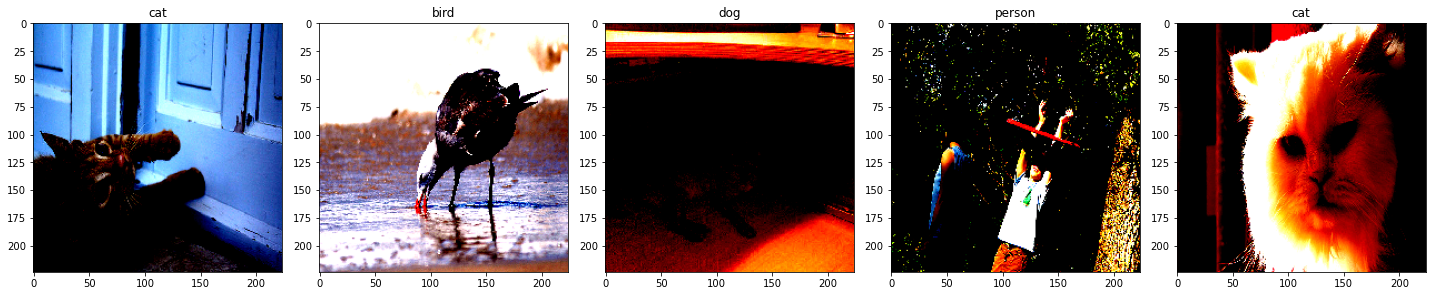

In [11]:
plotImages(sample_training_images[:5], labels[:5])

### Create "Callbacks" for Tensorboard monitor 

In [12]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 8, mode='min'),
    tf.keras.callbacks.ModelCheckpoint(filepath =os.path.join(PATH_log, 'COCO_'+dateTime+'_model.h5'), monitor = 'val_accuracy', save_best_only = True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1, patience = 2, verbose=1, mode='max'),
    tf.keras.callbacks.TensorBoard(log_dir = LogsDir, histogram_freq = 1, embeddings_freq = 1)
]

#### REGOLARIZZAZIONE

In [13]:
reg = tf.keras.regularizers.L1L2(l1=L1, l2=L2)

reg.__dict__

{'l1': array(1.e-04, dtype=float32), 'l2': array(0.1, dtype=float32)}

## Create the model

The model consists of ... VGG16

In [14]:
modelVGG = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224, 224, 3), pooling = 'max')
'''
for layer in modelVGG.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, reg)
          #print(layer.kernel_regularizer)
'''
modelVGG.trainable = True

# FINE TUNING
flagTrainable = False
for layer in modelVGG.layers:
    if 'block5' in layer.name:
        flagTrainable = True
    if flagTrainable:
        layer.trainable = True
    else:
        layer.trainable = False
        

modelVGG.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [15]:
layer_dict = dict([(layer.name, layer) for layer in modelVGG.layers])
#print(layer_dict)
#x = layer_dict['global_max_pooling2d'].output
x=modelVGG.output
# Classification block
x = Flatten(name='flatten')(x)
x = Dense(1024, activation='relu', name='fc1')(x)
#x = Dropout(0.25)(x)
x = Dense(1024, activation='relu', name='fc2')(x)
#x = Dropout(0.25)(x)
output_tensor = Dense(len(class_dict), activation='softmax', name='predictions')(x)

model = Model(inputs=modelVGG.input, outputs=output_tensor)

for layer in model.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, reg)
          #print(layer)

### Compile the model

For this tutorial, choose the *ADAM* optimizer and *binary cross entropy* loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [16]:
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Adam.__dict__

{'_use_locking': True,
 '_name': 'Adam',
 '_hyper': {'learning_rate': 1e-05,
  'decay': 0.0,
  'beta_1': 0.9,
  'beta_2': 0.999},
 '_slots': {},
 '_slot_names': [],
 '_weights': [],
 '_iterations': None,
 '_deferred_slot_restorations': {},
 '_initial_decay': 0.0,
 '_hypers_created': False,
 'epsilon': 1e-08,
 'amsgrad': False,
 '_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [],
 '_self_unconditional_dependency_names': {},
 '_self_unconditional_deferred_dependencies': {},
 '_self_update_uid': -1,
 '_self_name_based_restores': set()}

### Model summary

View all the layers of the network using the model's `summary` method:

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Train the model

Use the 'fit' (`fit_generator`) method of the `ImageDataGenerator` class to train the network.

In [18]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=epochs,
    callbacks = callbacks_list,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // batch_size
)
for key in history.history:
    print(key)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 64 steps, validate for 27 steps
Epoch 1/200
63/64 [============================>.] - ETA: 1s - loss: 1.1764 - accuracy: 0.4920
Epoch 00001: val_accuracy improved from -inf to 0.70139, saving model to E:Logs\VGG16\COCO\COCO_20200823-104504_model.h5
64/64 [==============================] - 85s 1s/step - loss: 1.1760 - accuracy: 0.4902 - val_loss: 0.8826 - val_accuracy: 0.7014
Epoch 2/200
63/64 [============================>.] - ETA: 0s - loss: 0.6286 - accuracy: 0.7908
Epoch 00002: val_accuracy improved from 0.70139 to 0.78935, saving model to E:Logs\VGG16\COCO\COCO_20200823-104504_model.h5
64/64 [==============================] - 60s 930ms/step - loss: 0.6250 - accuracy: 0.7931 - val_loss: 0.6365 - val_accuracy: 0.7894
Epoch 3/200
63/64 [============================>.] - ETA: 0s - loss: 0.3709 - accuracy: 0.8994
Epoch 00003: val_accuracy improved from 0.78935 to 0.79861, saving model to E:Logs\VGG16\COCO\COCO_20200823-104504_mo

### Visualize training results

Now visualize the results after training the network.

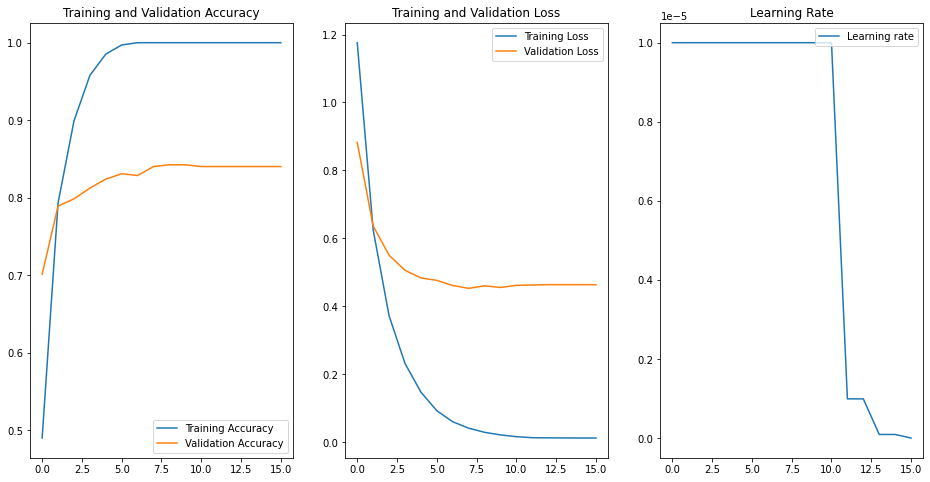

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

lr=history.history['lr']

epochs_range = range(len(acc))

plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, lr, label='Learning rate')
plt.legend(loc='upper right')
plt.title('Learning Rate')
plt.show()

In [20]:
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:16:20.347744


## Overfitting

## Data augmentation

In [21]:
dateTime = datetime.now().strftime("%Y%m%d-%H%M%S")

LogsDir = os.path.join(PATH_log, datetime.now().strftime("%Y%m%d-%H%M%S")) 

callbacks_list_2 = [
    tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 9),
    tf.keras.callbacks.ModelCheckpoint(filepath =os.path.join(PATH_log, 'Coco2_'+dateTime+'_model_2.h5'), monitor = 'val_accuracy', save_best_only = True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.05, patience = 2, verbose=1, mode='min'),
    tf.keras.callbacks.TensorBoard(log_dir = LogsDir, histogram_freq = 1, embeddings_freq = 1)
]

#### COSTANTI

In [22]:
L1 = 0.0001
L2 = 0.01

Adam = tf.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False, name='Adam')
RMSprop = tf.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False, name='RMSprop')
SGD = tf.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True, name='SGD')

opt2 = SGD

def std_setCoco(image):
    image = np.array(image)
    image -= IMAGE_MEAN
    #image /=IMAGE_STD
    return image

### Augment and visualize data

In [23]:
image_gen_train = ImageDataGenerator(
                    #preprocessing_function = std_setCoco,                
                    rescale=1./255,
                    rotation_range=45,
                    #width_shift_range=.15,
                    #height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5,
                    brightness_range=[0.6, 1.0],
                    validation_split=0.2
                    )

In [24]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical',
                                                     subset='training')

Found 1184 images belonging to 4 classes.


Visualize how a single image would look five different times when passing these augmentations randomly to the dataset.

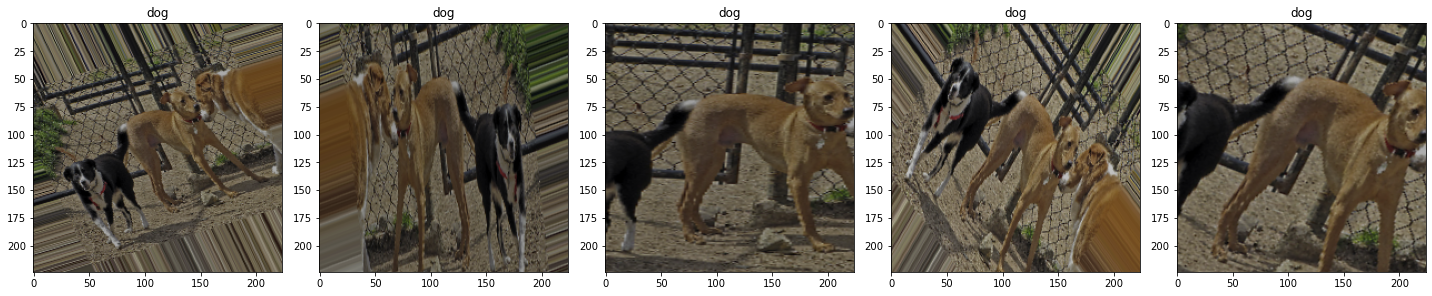

In [25]:
augmented_images, labels = [train_data_gen[0][0][0] for i in range(5)], [train_data_gen[0][1] for i in range(5)]
plotImages(augmented_images, labels)

### Create validation data generator

Generally, only apply data augmentation to the training examples. In this case, only rescale the validation images and convert them into batches using `ImageDataGenerator`.

In [26]:
# image_gen_val = ImageDataGenerator(rescale=1./255)

In [27]:
val_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                 directory=train_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='categorical',
                                                 subset='validation')

Found 296 images belonging to 4 classes.


#### REGOLARIZZAZIONE

In [28]:
import tensorflow as tf
reg = tf.keras.regularizers.L1L2(l1=L1, l2=L2)

reg.__dict__

{'l1': array(1.e-04, dtype=float32), 'l2': array(0.01, dtype=float32)}

## Dropout

## Creating a new network with Dropouts

In [29]:
from tensorflow.keras.layers import Dropout
'''
updated_model = Sequential()
for layer in model.layers:
    updated_model.add(layer)
    if layer.name in ['fc1', 'fc2'] or 'conv' in layer.name:
        updated_model.add(Dropout(.5))

model = updated_model
'''

layer_dict = dict([(layer.name, layer) for layer in modelVGG.layers])
#print(layer_dict)
#x = layer_dict['global_max_pooling2d'].output
x = modelVGG.output
# Classification block
x = Flatten(name='flatten')(x)
x = Dense(512, activation='relu', name='fc1')(x)
#x = Dropout(0.4)(x)
x = Dense(512, activation='relu', name='fc2')(x)
#x = Dropout(0.4)(x)
output_tensor = Dense(len(class_dict), activation='softmax', name='predictions')(x)

model = Model(inputs=modelVGG.input, outputs=output_tensor)

for layer in model.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, reg)
          print(layer.name)
model.summary()

block1_conv1
block1_conv2
block2_conv1
block2_conv2
block3_conv1
block3_conv2
block3_conv3
block4_conv1
block4_conv2
block4_conv3
block5_conv1
block5_conv2
block5_conv3
fc1
fc2
predictions
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
bl

### Compile the model

After introducing dropouts to the network, compile the model and view the layers summary.

In [30]:
model.compile(optimizer=opt2,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Adam.__dict__

{'_use_locking': True,
 '_name': 'Adam',
 '_hyper': {'learning_rate': 1e-05,
  'decay': 0.0,
  'beta_1': 0.9,
  'beta_2': 0.999},
 '_slots': {},
 '_slot_names': [],
 '_weights': [],
 '_iterations': None,
 '_deferred_slot_restorations': {},
 '_initial_decay': 0.0,
 '_hypers_created': False,
 'epsilon': 1e-08,
 'amsgrad': False}

### Train the model

After successfully introducing data augmentations to the training examples and adding dropouts to the network, train this new network:

In [31]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=epochs,
    callbacks = callbacks_list_2,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 74 steps, validate for 18 steps
Epoch 1/200
73/74 [============================>.] - ETA: 0s - loss: 1.2061 - accuracy: 0.4829
Epoch 00001: val_accuracy improved from -inf to 0.57292, saving model to E:Logs\VGG16\COCO\Voc2_20200823-110124_model_2.h5
74/74 [==============================] - 62s 839ms/step - loss: 1.2035 - accuracy: 0.4840 - val_loss: 1.0545 - val_accuracy: 0.5729
Epoch 2/200
73/74 [============================>.] - ETA: 0s - loss: 0.9768 - accuracy: 0.5985
Epoch 00002: val_accuracy improved from 0.57292 to 0.59028, saving model to E:Logs\VGG16\COCO\Voc2_20200823-110124_model_2.h5
74/74 [==============================] - 61s 826ms/step - loss: 0.9745 - accuracy: 0.5988 - val_loss: 0.9554 - val_accuracy: 0.5903
Epoch 3/200
73/74 [============================>.] - ETA: 0s - loss: 0.8679 - accuracy: 0.6301
Epoch 00003: val_accuracy improved from 0.59028 to 0.64931, saving model to E:Logs\VGG16\COCO\Voc2_20200823-11

### Visualize the model

Visualize the new model after training, you can see that there is significantly less overfitting than before. The accuracy should go up after training the model for more epochs.

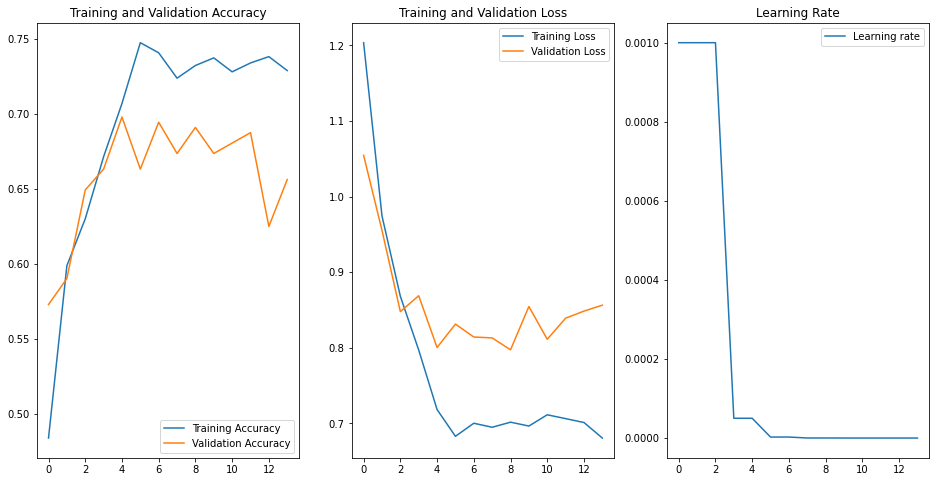

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

lr=history.history['lr']

epochs_range = range(len(acc))

plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, lr, label='Learning rate')
plt.legend(loc='upper right')
plt.title('Learning Rate')
plt.show()